In [74]:
import flv_utils as flv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

In [2]:
def get_trace_signal(data: dict, includ: list[int]):
    traces = data['neuron_traces'][includ]
    trace_mean = np.mean(traces, axis=1, keepdims=True)
    signal = np.std(traces / trace_mean, axis=1)
    return signal

def get_F_percentile(data: dict, includ: list[int]):
    traces = data['neuron_traces'][includ]
    trace_mean = np.mean(traces, axis=1, keepdims=True)
    F_p = {}
    for p in np.arange(0,101,2):
        F_p[p] = np.percentile(traces, p, axis=1)
    return F_p

In [3]:
def plot_heatmap(data, row_labels, col_labels, 
               figsize=(16,2.5), xrotation=90,
               xlabel='Neuron Classes', ylabel='Conditions', title='Heatmap',
               cmap='viridis', clim=[0,4]):
    """
    Create a heatmap with custom tick labels and colorbar.
    
    Parameters:
    - data: 2D numpy array
    - row_labels: list/array of strings for y-axis labels
    - col_labels: list/array of strings for x-axis labels
    - figsize: tuple for figure size
    - xrotation: rotation angle for x-axis labels
    - xlabel, ylabel, title: axis and plot labels
    - cmap: colormap name (default: 'viridis')
    - clim: list/tuple [vmin, vmax] to control colorbar range
    """
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create the heatmap with aspect ratio = 1 and clim
    im = ax.imshow(data, cmap=cmap, aspect=1, vmin=clim[0], vmax=clim[1])
    
    # Set tick labels
    ax.set_xticks(np.arange(len(col_labels)))
    ax.set_yticks(np.arange(len(row_labels)))
    ax.set_xticklabels(col_labels, fontsize=9)
    ax.set_yticklabels(row_labels, fontsize=9)
    
    # Rotate x-axis labels if needed
    plt.setp(ax.get_xticklabels(), rotation=xrotation, ha="right", rotation_mode="anchor")
    
    # Add colorbar with ticks and values
    vmin, vmax = im.get_clim()
    ticks = np.linspace(vmin, vmax, 5) 
    cbar = plt.colorbar(im, ax=ax, format='%.1f', ticks=ticks, extend='neither')
    cbar.ax.tick_params(labelsize=10)
    
    # Set labels
    ax.set_xlabel(xlabel, fontsize=14, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=14, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold')
    
    # Optional: Add grid
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", size=0)
    
    plt.tight_layout()
    return fig, ax, cbar

In [54]:
fig4_neuron_classes = [
    "AVB", "RIB", "RIC", "RID", "AUA", "AVJ", "AVK", "AIM", "AIY", "AIA",
    "AVA", "AVE", "AIB", "RIM", "AVL", "RIF", "RIV", "ADA", "AVD", "RMF",
    "RIA", "AVH", "RIR", "RIS", "RIH", "AIN", "RIP", "AIZ", "URB", "ALA",
    "RMG", "RMD", "RMDD", "RMDV", "RME", "RMEV", "RMED", "SAADL", "SAADR",
    "SAAV", "SMBV", "SMBD", "SMDV", "SMDD", "SIAV", "SIAD", "SIBV", "SIBD",
    "VB02", "ASJ", "IL1L", "IL1R", "IL1D", "IL1V", "URYD", "URYV", "BAG",
    "ASG", "CEPD", "CEPV", "OLL", "OLQD", "OLQV", "IL2L", "IL2R", "IL2D",
    "IL2V", "URAD", "URAV", "ADE", "FLP", "AQR", "URX", "ADL", "ASH", "ASEL",
    "ASER", "ASI", "AFD", "ASK", "AWA", "AWB", "AWC", "I1", "I2", "I3", "I4",
    "I5", "I6", "NSM", "M1", "M3", "M4", "M5", "MC", "MI"
]

# all_conditions = ['gfp', 'on_food', 'just_fed', '1h_starved']

dict_signal = {}
dict_F10 = {}
dict_F10_F90 = {}

for condition in all_conditions: # each group of datasets
    dict_signal[condition] = {}
    dict_F10[condition] = {}
    dict_F10_F90[condition] = {}

    for neuron_class in fig4_neuron_classes:  # each neuron class
        dict_signal[condition][neuron_class] = []
        dict_F10[condition][neuron_class] = []
        dict_F10_F90[condition][neuron_class] = []

        # pull all relevant neural traces
        try:
            if condition == 'copper':
                include = ['neuropal', 'copper']
                exclude = []
                length_bounds=(1600,1600)        
            elif condition == 'dense_food':
                include = ['neuropal', 'refed']
                exclude = []
                length_bounds=(800,800)
            elif condition == 'sparse_food':
                include = ['neuropal', 'baseline']
                exclude = ['gfp']
                length_bounds=(1600,1600)
            elif condition == 'gfp':
                include = ['neuropal', 'gfp']
                exclude=[]
                length_bounds=(1600,1600)
            elif condition == 'fasted':
                include = ['neuropal', 'fasted']
                exclude = []
                length_bounds=(1600,1600)
            elif condition == '1h_starved':
                include = ['neuropal', 'very_starved']
                exclude = ['gfp']
                length_bounds=(1600,1600)
            else:
                include = [condition]
                exclude = ['gfp']
                length_bounds=(1600,1600)
                
            data = flv.by_class(neuron_class, tag_filter=[], include=include, exclude=exclude, length_bounds=length_bounds, confidence_threshold=1)
            n_neuron = len(data['datasets'])
            # n_animal = len(set(data['datasets']))
            idx_all = np.arange(n_neuron)
            
        except:
            idx_all  = []

        for idx in idx_all:  # each trace
            signal = get_trace_signal(data, [idx])
            dict_signal[condition][neuron_class].append(signal[0])
            
            F_p = get_F_percentile(data, [idx])
            f10 = F_p[10]
            f90 = F_p[90]
            dynamic_range = (f90 - f10) / f10
            dict_F10[condition][neuron_class].append(f10[0])
            dict_F10_F90[condition][neuron_class].append(dynamic_range[0])

In [55]:
def dict_to_arr(input_dict: dict,
                all_conditions,
                all_neuron_classes):
    # turn into a single matrix for plotting
    n_conditions = len(all_conditions)
    n_neuron_class = len(all_neuron_classes)
    arr = np.full((n_conditions, n_neuron_class), np.nan)
    
    for (idx_cond, condition) in enumerate(all_conditions):  # each row of arr
        for (idx_neu, neuron_class) in enumerate(all_neuron_classes):  # each column of arr
            arr[idx_cond, idx_neu] = np.median(input_dict[condition][neuron_class])  # take the median of all traces

    return arr

/home/candy/.local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/candy/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


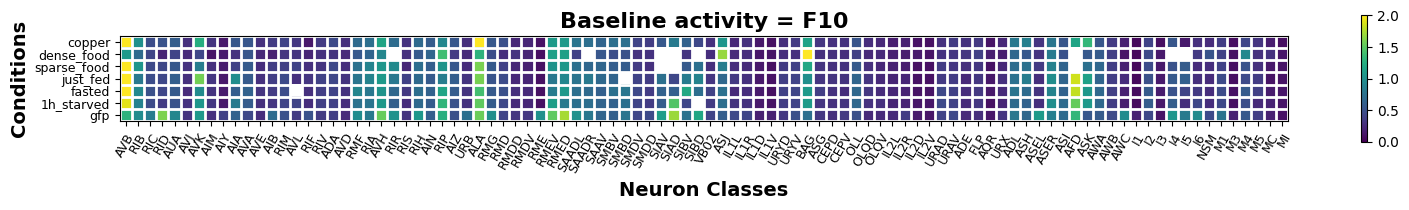

In [56]:
arr_F10 = dict_to_arr(dict_F10, all_conditions=all_conditions, all_neuron_classes=fig4_neuron_classes)
fig1, ax1, cbar1 = plot_heatmap(arr_F10, all_conditions, fig4_neuron_classes, clim=(0,2), xrotation=60, figsize=(16,2),
                                  cmap='viridis', title='Baseline activity = F10')
plt.savefig('baseline_activity_f10.png')

/home/candy/.local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/candy/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


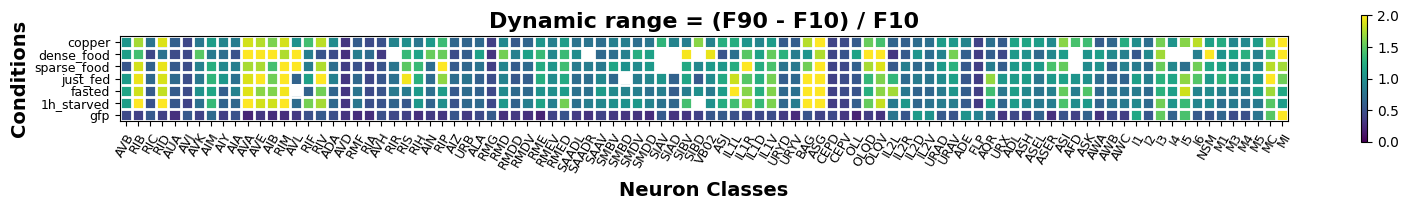

In [65]:
arr_dr = dict_to_arr(dict_F10_F90, all_conditions=all_conditions, all_neuron_classes=fig4_neuron_classes)
fig2, ax2, cbar2 = plot_heatmap(arr_dr, all_conditions, fig4_neuron_classes, 
                                clim=(0,2), xrotation=60, figsize=(16,2),
                                  cmap='viridis', title='Dynamic range = (F90 - F10) / F10')
plt.savefig('dynamic_range_f10_f90.png')

/home/candy/.local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/candy/.local/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


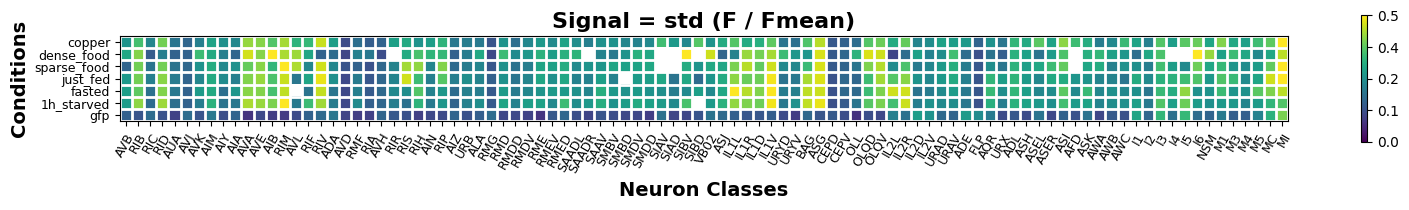

In [66]:
arr_sig = dict_to_arr(dict_signal, all_conditions=all_conditions, all_neuron_classes=fig4_neuron_classes)
fig3, ax3, cbar3 = plot_heatmap(arr_sig, all_conditions, fig4_neuron_classes, 
                                clim=(0,0.5), xrotation=60, figsize=(16,2),
                                  cmap='viridis', title='Signal = std (F / Fmean)')
plt.savefig('signal_std(Fmean).png')